In [83]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
# from nltk.tokenize import word_tokenize
from underthesea import text_normalize
from underthesea import word_tokenize

import nltk
from sklearn.model_selection import train_test_split
from collections import Counter
import re
from datasets import load_dataset
from classes import SentimentDataset
from collections import Counter
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')
from stopwordsiso import stopwords
import string
import dataset

[nltk_data] Downloading package punkt to /home/vuong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [84]:
nltk.data.find('tokenizers/punkt')  # Kiểm tra xem đã có chưa
nltk.download('punkt', force=True)
nltk.download('punkt_tab')
vietnamese_stopwords = stopwords(['vi'])

[nltk_data] Downloading package punkt to /home/vuong/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /home/vuong/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [85]:
# data = pd.read_csv('neutral.csv').dropna()
# data = data.rename(columns={'sentence': 'text', 'sentiment': 'label'})


In [119]:
dataset = load_dataset("uit-nlp/vietnamese_students_feedback") # https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8573337
data_neutral = pd.read_csv('neutral.csv')
train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

# # Concatenate all DataFrames into one (so data is more objective and balance)
data = pd.concat([train_df, val_df, test_df], ignore_index=True)
# # Randomly mix/shuffle the DataFrame
# data = data.sample(frac=1).reset_index(drop=True)
data.rename(columns = {'sentence': 'text', 'sentiment': 'label'}, inplace = True)
data = pd.concat([data,data_neutral], ignore_index=True)


In [120]:
data

,text,label,topic
0,slide giáo trình đầy đủ .,2,1
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2,0
2,đi học đầy đủ full điểm chuyên cần .,0,1
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2,0
...,...,...,...
20234,The facilities of the university are versatile...,1,facility
20235,Cậu ấy rất có kỹ năng về sáng tạo và nghệ thuật.,1,others
20236,Anh ta là một người rất tỉ mỉ và cẩn thận.,1,others
20237,Giáo viên đưa ra các phương tiện hỗ trợ giảng ...,1,curriculum


In [88]:
data.to_csv('data.csv', index=False)

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20874 entries, 0 to 20873
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20874 non-null  object
 1   label   20874 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 326.3+ KB


In [90]:
data.isnull().sum()

text     0
label    0
dtype: int64

In [91]:
duplicates = data[data.duplicated(subset='text', keep=False)]
print(duplicates)

                                                    text  label
11292  thầy dạy hay , tuy nhiên còn nhiều chỗ chưa th...      2
11416  thầy dạy hay , tuy nhiên còn nhiều chỗ chưa th...      0
16413                             Em không có ý kiến gì.      1
16417                                 Chưa có gì để nói.      1
16421                        Em không có gì để nói thêm.      1
...                                                  ...    ...
20869  The facilities of the university are versatile...      1
20870   Cậu ấy rất có kỹ năng về sáng tạo và nghệ thuật.      1
20871         Anh ta là một người rất tỉ mỉ và cẩn thận.      1
20872  Giáo viên đưa ra các phương tiện hỗ trợ giảng ...      1
20873  The university's computer facilities are up-to...      1

[1406 rows x 2 columns]


In [92]:
data = data.drop_duplicates(subset=['text'], keep='first')

In [93]:
data

,text,label
0,slide giáo trình đầy đủ .,2
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2
2,đi học đầy đủ full điểm chuyên cần .,0
3,chưa áp dụng công nghệ thông tin và các thiết ...,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2
...,...,...
20199,The facilities of the university are versatile...,1
20200,Cậu ấy rất có kỹ năng về sáng tạo và nghệ thuật.,1
20201,Anh ta là một người rất tỉ mỉ và cẩn thận.,1
20202,Giáo viên đưa ra các phương tiện hỗ trợ giảng ...,1


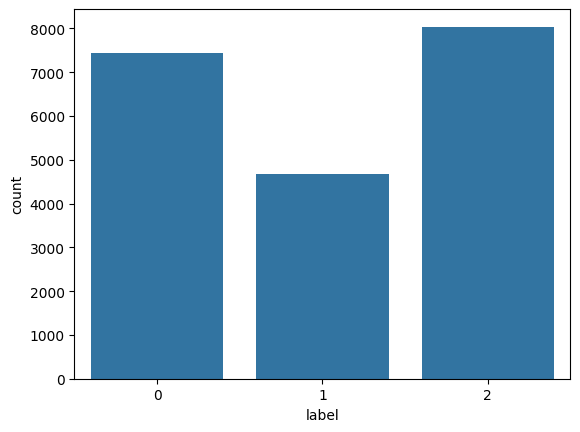

In [94]:
import seaborn as sb
x = sb.countplot(x='label',data=data)

In [95]:
data[data['label']==') .']

,text,label


In [96]:
# import re
# from tqdm import tqdm

# # Làm sạch dữ liệu trong DataFrame gốc
# data["text"] = data["text"].str.strip().str.replace("\n", " ")

# # Tiền xử lý: chuyển thường, loại bỏ ký tự đặc biệt, khoảng trắng dư thừa
# texts = [re.sub(r"[^\w\s]", "", t.lower()) for t in data["text"]]
# texts = [' '.join(t.split()) for t in texts]

# # Tokenization thủ công (nếu muốn giữ dưới dạng list các từ)
# tokens = [t.split() for t in texts]

# # Ghép lại thành văn bản nếu cần đầu ra là string
# texts = [' '.join(t) for t in tokens]

In [97]:
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"
                u"\U0001F300-\U0001F5FF" 
                u"\U0001F680-\U0001F6FF"  
                u"\U0001F1E0-\U0001F1FF"  
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE) # Unicode emojis. 

def clean_text(text):
    text = text.lower() # lowercase text
    
    text = re.sub(emoji_pattern, " ", text) # remove emojis
    
    text = re.sub(r'([a-z]+?)\1+',r'\1', text) # reduce repeated character (e.g. 'aaabbb' -> 'ab')
    
    # Ensure space before and after any punctuation mark
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)
    
    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+",r"\1", text) # reduce consecutive punctuation
    
    # Remove any leading or trailing spaces, or leading or trailing punctuation marks from the text
    text = text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]
        
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuation
        
    text = re.sub(r"\s+", " ", text) # reduce multiple spaces
    
    text = text_normalize(text) # make sure punctunation is in the right letter (Vietnamese case)
    text = word_tokenize(text, format="text") # tokenize the cleaned text
    # text = unidecode(text) # remove accent marks from sentences (no significant difference when accent marks is removed or kept)
    
    '''
    Proper tokenization allows models or algorithms to understand the semantics of the text better. 
    For instance, `"đi chơi" (go play)` should be treated as one unit 
    instead of two separate words "đi" (go) and "chơi" (play) for proper semantic understanding.
    '''
    return text

In [98]:
data['corpus'] = data['text'].map(lambda text: clean_text(text))                                                     
# Final check
data

/tmp/ipykernel_6340/4049566014.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['corpus'] = data['text'].map(lambda text: clean_text(text))


,text,label,corpus
0,slide giáo trình đầy đủ .,2,slide giáo_trình đầy_đủ
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2,nhiệt_tình giảng_dạy gần_gũi với sinh_viên
2,đi học đầy đủ full điểm chuyên cần .,0,đi học đầy_đủ ful_điểm chuyên cần
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,chưa áp_dụng công_nghệ_thông_tin và các thiết_...
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2,thầy giảng bài hay có nhiều bài_tập ví_dụ ngay...
...,...,...,...
20199,The facilities of the university are versatile...,1,the facilities of_the university are versatile...
20200,Cậu ấy rất có kỹ năng về sáng tạo và nghệ thuật.,1,cậu ấy rất có kỹ_năng về sáng_tạo và nghệ_thuật
20201,Anh ta là một người rất tỉ mỉ và cẩn thận.,1,anh ta là một người rất tỉ_mỉ và cẩn_thận
20202,Giáo viên đưa ra các phương tiện hỗ trợ giảng ...,1,giáo_viên đưa ra các phương_tiện hỗ_trợ giảng_...


In [99]:
# texts = data['corpus']
# len(texts)

In [100]:

# labels = data['label'].map({'negative': 0, 'positive': 1, 'neutral': 2}).tolist()
# labels = data['label']
labels = data['label'].tolist()
texts = data['corpus']
# dataset = SentimentDataset(texts, labels)

# tokenized_texts = [word_tokenize(t) for t in texts]

tokenized_texts = [
    [word for word in word_tokenize(t) if word not in vietnamese_stopwords]
    for t in texts
]

In [101]:
print(len(texts), len(labels))  # Cần phải bằng nhau

20155 20155


Max length: 61
Mean length: 5.763284544777971
Median length: 5.0
90th percentile: 10.0
95th percentile: 13.0
99th percentile: 19.0


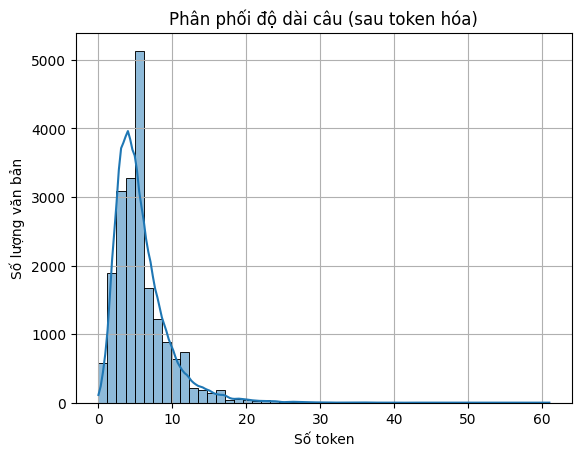

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
lengths = [len(seq) for seq in tokenized_texts]

print("Max length:", max(lengths))
print("Mean length:", np.mean(lengths))
print("Median length:", np.median(lengths))
print("90th percentile:", np.percentile(lengths, 90))
print("95th percentile:", np.percentile(lengths, 95))
print("99th percentile:", np.percentile(lengths, 99))

sns.histplot(lengths, bins=50, kde=True)
plt.title("Phân phối độ dài câu (sau token hóa)")
plt.xlabel("Số token")
plt.ylabel("Số lượng văn bản")
plt.grid(True)
plt.show()

In [103]:

all_words = [w for txt in tokenized_texts for w in txt]
most_common = Counter(all_words).most_common(4998)

vocab = {'<PAD>': 0, '<UNK>': 1}
for i, (w, _) in enumerate(most_common, 2):
    vocab[w] = i

def to_indices(tokens, max_len):
    idxs = [vocab.get(t, 1) for t in tokens][:max_len]
    return idxs + [0] * (max_len - len(idxs))

max_len_text = 20
text_indices = [to_indices(t, max_len_text) for t in tokenized_texts]

In [104]:
train_texts, test_texts, train_labels, test_labels = train_test_split(text_indices, labels, test_size=0.2, random_state=42)

In [105]:
train_dataset = SentimentDataset(train_texts, train_labels)
test_dataset = SentimentDataset(test_texts, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [106]:
data_to_save = {
    'train_loader': train_loader,
    'test_loader': test_loader,
    'batch_size': 32,
    'vocab': vocab,
    'vocab_size': len(vocab)
}
save_path = 'sentiment_data_loader.pth'
torch.save(data_to_save, save_path)